In [1]:
import functions as fx
import log_reg_functions as lrf
import loaddata as ld
import NeuralNetwork as nn

import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPRegressor

# D
Creating the Franke function with noise.

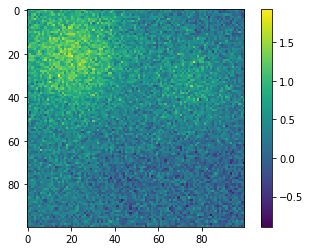

In [2]:
n=100
x = np.linspace(0,1,n)
y = x
x_mesh, y_mesh  = np.meshgrid(x,y)
noise_level     = 0.25
frank           = fx.FrankeFunction(x_mesh, y_mesh, noise_level)

plt.imshow(frank)
plt.colorbar()
plt.show()

frank=frank.ravel()
frank=frank.reshape([len(frank),1])
design=fx.DesignDesign(x,y,8)


In [3]:
epochs=1000
batch_size=int(len(frank)/20)
n_features=design.shape[1]
etavec = np.logspace(-6, -1, 6)
lmbvec = np.logspace(-6, -1, 6)
lmbvec[0]=0
k=5
activation = [lrf.relu, lrf.sigmoid, lrf.relu]
derivative = [lrf.relu_deriv, lrf.sigmoid_deriv, lrf.relu_deriv]



y_folds, x_folds = lrf.k_fold_reshaper(k,frank,design,shuffle=True)
test_loss = np.zeros((len(etavec), len(lmbvec)))
test_r2 = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=lmb, bias=0, eta=etas,early_stop_tol = 10e-04,\
                                early_stop_nochange=200, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,80,40], n_neurons = [80,40,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=False)

            pred = neural_net.feed_out(xtest, activation)
            test_loss[i,j] +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2[i,j] +=  fx.R2Score(pred.ravel(),ytest.T)
            
        print('test loss for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', test_loss [i,j]/k)

test_loss = test_loss/k
test_r2 = test_r2/k

test loss for η = 1e-06 & λ = 0.0 = 0.11663495128231802
test loss for η = 1e-06 & λ = 1e-05 = 0.11663496109974894
test loss for η = 1e-06 & λ = 0.0001 = 0.11663901534272034
test loss for η = 1e-06 & λ = 0.001 = 0.11664187382612604
test loss for η = 1e-06 & λ = 0.01 = 0.11669884703964181
test loss for η = 1e-06 & λ = 0.1 = 0.11716736175162343
test loss for η = 1e-05 & λ = 0.0 = 0.09517487002950276
test loss for η = 1e-05 & λ = 1e-05 = 0.09517490690739583
test loss for η = 1e-05 & λ = 0.0001 = 0.09517523882954922
test loss for η = 1e-05 & λ = 0.001 = 0.09517855889132318
test loss for η = 1e-05 & λ = 0.01 = 0.09521194694908168
test loss for η = 1e-05 & λ = 0.1 = 0.09556363771221114
test loss for η = 0.0001 & λ = 0.0 = 0.08793356892682963
test loss for η = 0.0001 & λ = 1e-05 = 0.08793375227936273
test loss for η = 0.0001 & λ = 0.0001 = 0.08793540311162346
test loss for η = 0.0001 & λ = 0.001 = 0.087961804922381
test loss for η = 0.0001 & λ = 0.01 = 0.08820470001867779
test loss for η = 0.0

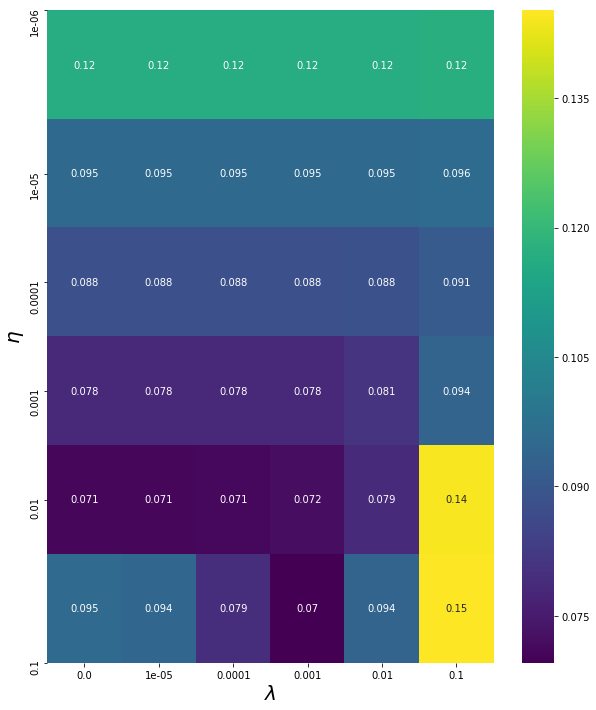

In [4]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_loss, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

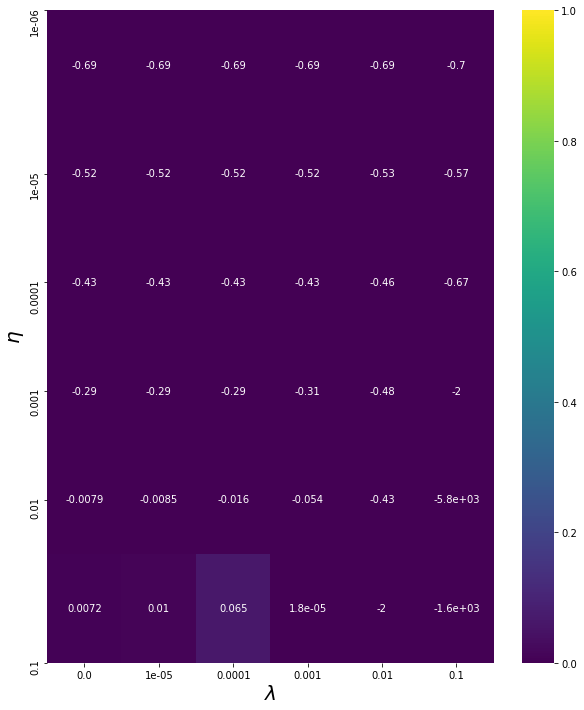

In [5]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_r2, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels, vmin=0, vmax=1)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

In [6]:
best_eta_index, best_lmb_index = np.where(test_loss == np.min(test_loss))
best_eta,best_lmb = etavec[best_eta_index], lmbvec[best_lmb_index] 
print('eta=',best_eta)
print('lmb=',best_lmb)

eta= [0.1]
lmb= [0.001]


In [ ]:
neural_net = nn.ANN(lmb=0, bias=0.5, eta=best_eta,early_stop_tol = 10e-04,\
                            early_stop_nochange=200, mode= 'regression')            
neural_net.add_layers(n_features=[n_features,50,20], n_neurons = [50,20,1] , n_layers=3)
activation = [lrf.relu, lrf.sigmoid, lrf.relu]
derivative = [lrf.relu_deriv, lrf.sigmoid_deriv, lrf.relu_deriv]
epochs = 1000
neural_net.train(epochs, batch_size, xtrain , ytrain ,activation,derivative, xval, yval, verbose=True)


pred = neural_net.feed_out(xtrain, activation)
train_error = fx.R2Score(ytrain,pred)
train_mse = fx.MSE(ytrain,pred)
pred = neural_net.feed_out(xval, activation)
validation_error = fx.R2Score(yval,pred)
validation_mse = fx.MSE(yval,pred)
pred = neural_net.feed_out(xtest, activation)
test_error = fx.R2Score(ytest,pred)
test_mse = fx.MSE(ytest,pred)

print('training R2',  train_error, 'and MSE=', train_mse )
print('validation R2',  validation_error, 'and MSE=', validation_mse )
print('training R2',  test_error, 'and MSE=', test_mse )

In [7]:

for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=best_lmb, bias=0, eta=best_eta,early_stop_tol = 10e-4,\
                                early_stop_nochange=200, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,50,20], n_neurons = [50,20,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=True)

            pred = neural_net.feed_out(xtest, activation)
            test_loss_best +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2_best +=  fx.R2Score(pred.ravel(),ytest.T)

test_loss_best /= k
test_r2_best /= k
cost_test, cost_train = neural_net.costs()
print(test_r2_best, 'r2 score')
print(test_loss_best, 'MSE')
            

Epoch 1 loss 0.1097119944149407
Epoch 2 loss 0.0932479729846014
Epoch 3 loss 0.08922399254237465
Epoch 4 loss 0.08625987621257283
Epoch 5 loss 0.08503164348999845
Epoch 6 loss 0.08338531696269234
Epoch 7 loss 0.08211417228804149
Epoch 8 loss 0.08114680509284418
Epoch 9 loss 0.08064124477367883
Epoch 10 loss 0.07951253643897661
Epoch 11 loss 0.07884031632723741
Epoch 12 loss 0.07829064176761495
Epoch 13 loss 0.07781089048619423
Epoch 14 loss 0.07736729241247813
Epoch 15 loss 0.07710279636601979
Epoch 16 loss 0.07654166101262802
Epoch 17 loss 0.07615771861912264
Epoch 18 loss 0.07590545734526896
Epoch 19 loss 0.0758105787178219
Epoch 20 loss 0.07521745402149731
Epoch 21 loss 0.07515644871057223
Epoch 22 loss 0.07498622524307899
Epoch 23 loss 0.07476579768185505
Epoch 24 loss 0.074583399760204
Epoch 25 loss 0.07483288094494324
Epoch 26 loss 0.0746399034950968
Epoch 27 loss 0.07429345823398693
Epoch 28 loss 0.07398894125133262
Epoch 29 loss 0.07389777358945963
Epoch 30 loss 0.0736764688036

Epoch 241 loss 0.06888938168507923
Epoch 242 loss 0.06873953626318823
Epoch 243 loss 0.06827408567281401
Epoch 244 loss 0.06874764689897644


NameError: name 'test_loss_best' is not defined

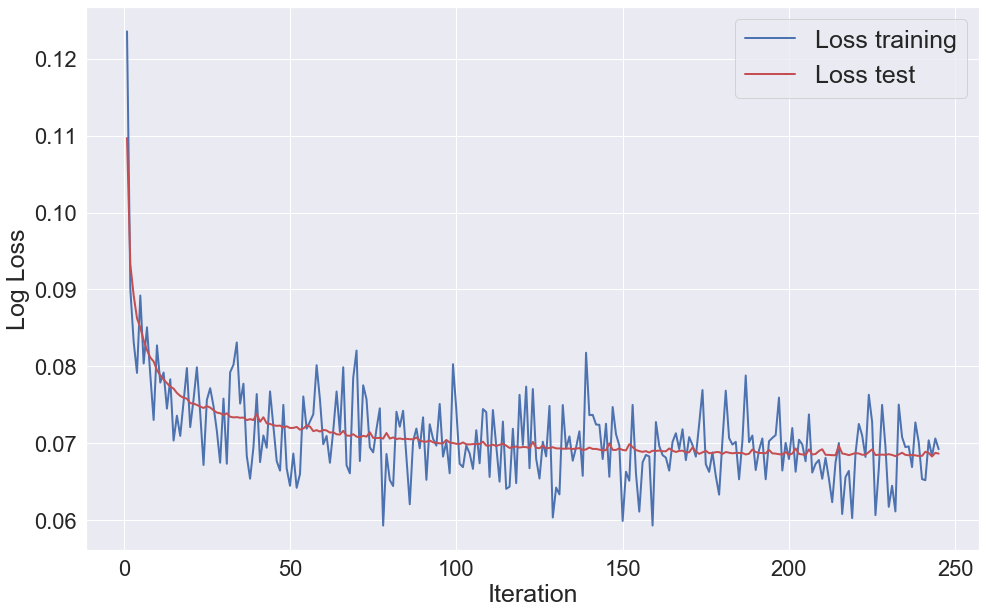

In [9]:
cost_test, cost_train = neural_net.costs()

sns.set(font_scale=2)
plt.figure(figsize=([16,10]))
axis = np.arange(len(cost_train))+1
plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
plt.legend(fontsize=25)
plt.ylabel('Log Loss',fontsize=25)
plt.xlabel('Iteration',fontsize=25)
plt.show()

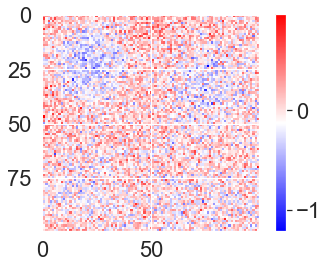

0.5260816980081415


In [10]:
pred = neural_net.feed_out(design, activation)

#plt.subplot(1, 2, 1)
plt.imshow(pred.reshape([n,n])- frank.reshape([n,n]), cmap='bwr')
#plt.subtitle('Predicted')
#plt.subplot(1, 2, 2)
#plt.subtitle('Franke')
#plt.imshow(frank.reshape([n,n]))
plt.colorbar()
plt.show()





print(fx.R2Score(frank.ravel(),pred.ravel()))

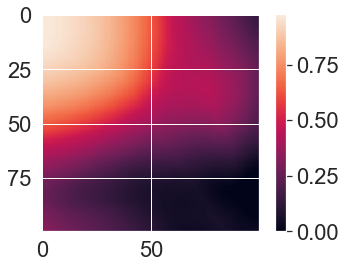

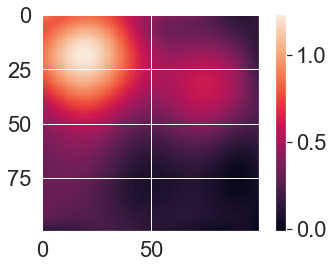

In [11]:
pred = neural_net.feed_out(design, activation)
plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

beta, pred = fx.OridinaryLeastSquares(design, frank, design)
plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()



0.9830693657460222
0.9786826488472629
0.9589358385108006
0.9294037892891827
0.8021417174789522
0.4556894278548118
-3.976163083607709e-05
0.9972687748786746
0.9880647576768603
0.9813564713925473
0.9295816195560719
0.8166500647601069
0.543778138626378
-0.0029691409423500126


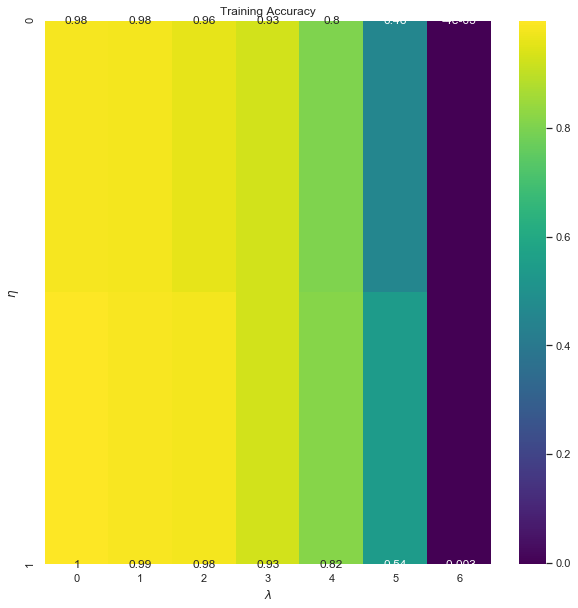

In [54]:
design=fx.DesignDesign(x,y,8)
design=np.delete(design, [0,1], axis=1)

X_train = design
Y_train = frank.ravel()

n_hidden_neurons = (50,20)
epochs = 1000
eta_vals = np.logspace(-2, -1, 2)
lmbd_vals = np.logspace(-5, 1, 7)
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn
        train_accuracy[i][j] = dnn.score(X_train, Y_train)
        print(train_accuracy[i][j])
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [55]:
best_eta_index, best_lmb_index = np.where(train_accuracy == np.max(train_accuracy))
best_eta,best_lmb = eta_vals[best_eta_index], lmb_vals[best_lmb_index] 
print(best_eta, 'eta')
print(best_lmb, 'lmb') 


dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbmax, learning_rate_init=etamax, max_iter=epochs*100)
dnn.fit(X_train, Y_train)
DNN_scikit = dnn
train_accuracy = dnn.score(X_train, Y_train)
print(train_accuracy)

NameError: name 'lmb_vals' is not defined

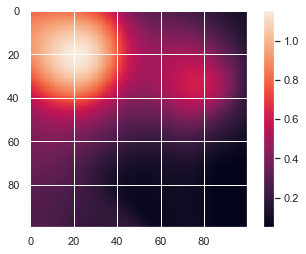

0.9950208839592649


In [49]:
pred = dnn.predict(X_train)


plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

print(fx.R2Score(pred,frank.ravel()))